In [1]:
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tarfile
from os import path
from tensorflow.keras import layers
from tensorflow import keras
import python_splitter
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.models import load_model
import cv2
from tensorflow.keras.models import Model

In [2]:
items = os.listdir('custom_dataset/Images')
items.sort()
dog_categories = [];
for item in items:
    dog_categories.append(item.split('-')[1])

In [3]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, val_data, dog_categories):
        super().__init__()
        self.validation_data = val_data
    def on_train_begin(self, logs={}):
        self._data = {}
        for dog_category in dog_categories:
                self._data[dog_category] = {
                        'vrai positif': 0,
                        'faux positif': 0,
                        'precision':0
                    }

    def on_epoch_end(self, batch, logs={}):
        for x_test, y_test in self.validation_data:
            y_predict = np.asarray(model.predict(x_test, verbose=0))

            true = np.argmax(y_test, axis=1)
            pred = np.argmax(y_predict, axis=1)
            predictions = zip(true, pred);
            for test, prediction in predictions:
                if test == prediction:
                    self._data[dog_categories[test]]['vrai positif'] = self._data[dog_categories[test]]['vrai positif'] + 1
                if test != prediction:
                    self._data[dog_categories[prediction]]['faux positif'] = self._data[dog_categories[prediction]]['faux positif'] + 1
        return

    def get_data(self):
        for data in self._data:
            self._data[data]['precision'] = self._data[data]['vrai positif'] / (self._data[data]['vrai positif'] + self._data[data]['faux positif'])
        return self._data

In [4]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
if path.isdir('Train_Test_Folder'):
    shutil.rmtree("Train_Test_Folder")
python_splitter.split_from_folder("/data/custom_dataset/Images", train = 0.7, test = 0.25)

✅Checking SOURCE directory...
0.7 0 0.25
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


Je charge mes datasets

In [6]:
BATCH_SIZE = 32
IMG_SIZE = 224
NB_CLASS = 120
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/train'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/test'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/val'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 14355 files belonging to 120 classes.
Found 1077 files belonging to 120 classes.
Found 5148 files belonging to 120 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Je transforme mes classe en one hot

In [8]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Utilisation de mobilenet v2

In [9]:
model = load_model('Modele_transfert.h5')

Pour générer des prédictions à partir du bloc d'entités, effectuez une moyenne sur les emplacements spatiaux 5x5 , à l'aide d'une couche tf.keras.layers.GlobalAveragePooling2D pour convertir les entités en un seul vecteur de 1 280 éléments par image.

On construit le modèle

In [10]:
len(model.trainable_variables)

4

In [11]:

#5 et 0.00001 pas mal
for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
        
len(model.trainable_variables)

176

In [12]:
loss0, accuracy0 = model.evaluate(test_dataset)

34/34 [==============================] - 6s 110ms/step - loss: 0.4329 - categorical_accuracy: 0.8626


In [13]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0000075),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
              )

In [14]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

In [15]:
metrics = Metrics(val_data = validation_dataset, dog_categories = dog_categories)

In [16]:
EPOCHS = 5

history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data=validation_dataset, 
                    verbose=1,
                    callbacks =[earlystopping, metrics])

Epoch 1/5


2023-02-28 23:18:44.895312: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-28 23:18:44.895358: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-28 23:18:44.920615: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-28 23:18:44.920643: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

448/449 [============================>.] - ETA: 0s - loss: 0.9825 - categorical_accuracy: 0.7225

2023-02-28 23:24:08.572506: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-28 23:24:08.572553: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-28 23:24:09.144137: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-28 23:24:09.144182: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

449/449 [==============================] - 372s 787ms/step - loss: 0.9824 - categorical_accuracy: 0.7226 - val_loss: 0.4506 - val_categorical_accuracy: 0.8706
Epoch 2/5
449/449 [==============================] - 346s 771ms/step - loss: 0.8444 - categorical_accuracy: 0.7569 - val_loss: 0.4384 - val_categorical_accuracy: 0.8681
Epoch 3/5
449/449 [==============================] - 352s 784ms/step - loss: 0.7750 - categorical_accuracy: 0.7744 - val_loss: 0.4376 - val_categorical_accuracy: 0.8697
Epoch 4/5
449/449 [==============================] - 346s 770ms/step - loss: 0.6940 - categorical_accuracy: 0.7871 - val_loss: 0.4386 - val_categorical_accuracy: 0.8699
Epoch 5/5
449/449 [==============================] - 346s 771ms/step - loss: 0.6600 - categorical_accuracy: 0.7987 - val_loss: 0.4366 - val_categorical_accuracy: 0.8716


In [17]:
metrics.get_data()

{'Chihuahua': {'vrai positif': 157,
  'faux positif': 11,
  'precision': 0.9345238095238095},
 'Japanese_spaniel': {'vrai positif': 198,
  'faux positif': 17,
  'precision': 0.9209302325581395},
 'Maltese_dog': {'vrai positif': 256,
  'faux positif': 18,
  'precision': 0.9343065693430657},
 'Pekinese': {'vrai positif': 166,
  'faux positif': 18,
  'precision': 0.9021739130434783},
 'Shih': {'vrai positif': 218,
  'faux positif': 48,
  'precision': 0.8195488721804511},
 'Blenheim_spaniel': {'vrai positif': 221,
  'faux positif': 14,
  'precision': 0.9404255319148936},
 'papillon': {'vrai positif': 232,
  'faux positif': 6,
  'precision': 0.9747899159663865},
 'toy_terrier': {'vrai positif': 189,
  'faux positif': 18,
  'precision': 0.9130434782608695},
 'Rhodesian_ridgeback': {'vrai positif': 155,
  'faux positif': 40,
  'precision': 0.7948717948717948},
 'Afghan_hound': {'vrai positif': 293,
  'faux positif': 15,
  'precision': 0.9512987012987013},
 'basset': {'vrai positif': 208,
  'f

In [18]:
loss0, accuracy0 = model.evaluate(test_dataset)

34/34 [==============================] - 3s 87ms/step - loss: 0.4212 - categorical_accuracy: 0.8756


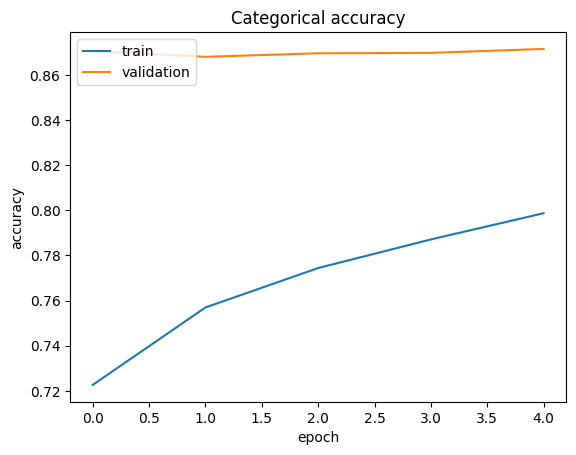

In [19]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)